#Conformational Design!
For designing protein variants with altered conformational state preference. Updated 12/18/2024. Enabled by code from ColabDesign codebase.



In [ ]:
#@title Install colabdesign and other requirements
import os
!pip install numpy==1.26.4

try:
  import colabdesign
except:
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  os.system("ln -s /usr/local/lib/python3.7/dist-packages/colabdesign colabdesign")

from colabdesign.mpnn import mk_mpnn_model, clear_mem
from colabdesign.shared.protein import pdb_to_string

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
from tqdm.notebook import tqdm

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

from google.colab import files
from google.colab import data_table
data_table.enable_dataframe_formatter()

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

In [ ]:
#@title Set up structures and model

#@markdown Structures should be for the same protein, with similar resolution, with ideally no mutations. Regions where structure is not solved will not be scored. Upload of custom PDB files is a work in progress.

#@markdown #### Job Name
jobname = "lpla" #@param {type:"string"}

#@markdown #### Input Protein Sequence
sequence = "STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIGRAQNPWKECNTRRMEEDNVRLARRSSGGGAVFHDLGNTCFTFMAGKPEYDKTISTSIVLNALNALGVSAEASGRNDLVVKTVEGDRKVSGSAYRETKDRGFHHGTLLLNADLSRLANYLNPDKKKLAAKGITSVRSRVTNLTELLPGITHEQVCEAITEAFFAHYGERVEAEIISPNKTPDLPNFAETFARQSSWEWNFGQAPAFSHLLDERFTWGGVELHFDVEKGHITRAQVFTDSLNPAPLEALAGRLQGCLYRADMLQQECEALLVDFPEQEKELRELSAWMAGAVR" #@param {type:"string"}

#@markdown #### Specify State 1 structure
state1_pdb = "3A7R" #@param {type:"string"}
state1_chain = "A" #@param {type:"string"}

#@markdown #### Specify State 2 structure
state2_pdb = "1X2G" #@param {type:"string"}
state2_chain = "A" #@param {type:"string"}

s1_path = get_pdb(state1_pdb)
s2_path = get_pdb(state2_pdb)

from Bio.Align import PairwiseAligner
from colabdesign.shared.protein import pdb_to_string
from colabdesign.af.alphafold.common import protein

aa_alphabet = "ARNDCQEGHILKMFPSTWYV"

def setup_aligner():
    aligner = PairwiseAligner()
    aligner.mode = "global"
    aligner.open_gap_score = -10
    aligner.extend_gap_score = -0.5
    aligner.match_score = 2
    aligner.mismatch_score = -0.5
    return aligner

def alignment_to_mapping(alignment, allow_mismatches=True):
    mapping = {}
    current_a_idx = 0
    current_b_idx = 0
    n_mismatches = 0
    for i, (a, b) in enumerate(zip(alignment[0], alignment[1])):
        if a != "-" and b != "-":
            if allow_mismatches or a == b:
                mapping[current_a_idx] = current_b_idx
            else:
                n_mismatches += 1
            current_a_idx += 1
            current_b_idx += 1
        elif a != "-":
            current_a_idx += 1
        elif b != "-":
            current_b_idx += 1
    if allow_mismatches and n_mismatches > 0:
        print(f"WARNING: {n_mismatches} mismatches included in alignment!")
    return mapping


def mapping_to_sequence(scaffold_seq, target_seq, mapping, fill=True, fill_char="A"):
    """make scorable sequence"""
    seq = ["-"] * (np.max(list(mapping.values())) + 1)
    for i, c in enumerate(scaffold_seq):
        if i in mapping:
            seq[mapping[i]] = c
    seq = "".join(seq)
    seq = [c for c in seq.strip("-")]  # remove leading/trailing hyphens
    # fill in gaps with target seq
    for i in range(len(seq)):
        if seq[i] == "-":
            seq[i] = target_seq[i]
    if fill:
        filled = 0
        for i, val in enumerate(seq):
            if val not in aa_alphabet:
                seq[i] = fill_char
                filled += 1
        if filled > 0:
            print(f"WARNING: Filled in {filled} missing AAs with {fill_char}")
    else:
        if "-" in seq:
            raise ValueError("Incomplete Mapping Provided!")
        if "*" in seq or "?" in seq:
            raise ValueError(
                "Incomplete sequences provided (wild-card characters present)"
            )
    return "".join(seq)

def make_consensus_sequence(sequences):
    aligner = setup_aligner()
    template_seq = sequences[0]
    for seq in sequences[1:]:
        alignment = aligner.align(template_seq, seq)[0]
        seq1, seq2 = alignment[0], alignment[1]
        template_seq = ""
        for a, b in zip(seq1, seq2):
            if a in aa_alphabet:
                template_seq += a
            elif b in aa_alphabet:
                template_seq += b
            else:
                template_seq += "*"
    return template_seq

def get_mpnn_seq(pdb_fp, chain):
    pdb_str = pdb_to_string(pdb_fp, chains=[chain], models=[1])
    protein_obj = protein.from_pdb_string(pdb_str, chain_id=chain)

    return "".join([aa_alphabet[i] for i in protein_obj.aatype])

pdbs = {
    "state1": s1_path,
    "state2": s2_path,
}

chains = {
    'state1': state1_chain,
    'state2': state2_chain,
}

seqs = {pdb: get_mpnn_seq(pdbs[pdb], chains[pdb]) for pdb in pdbs}
con_seq = make_consensus_sequence([sequence] + list(seqs.values()))

aligner = setup_aligner()
alignments = {pdb: aligner.align(con_seq, seq)[0] for pdb, seq in seqs.items()}

mappings = {
    pdb: alignment_to_mapping(alignment) for pdb, alignment in alignments.items()
}

homooligomer = False  # if structure is a homooligomer
fix_pos = None
inverse = True  # whether to invert the fix pos selection
model_name = "v_48_020"  # ["v_48_002", "v_48_010", "v_48_020", "v_48_030"]

if "mpnn_model" not in dir():
    mpnn_model = mk_mpnn_model(model_name)



Consensus sequence: STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIGRAQNPWKECNTRRMEEDNVRLARRSSGGGAVFHDLGNTCFTFMAGKPEYDKTISTSIVLNALNALGVSAEASGRNDLVVKTVEGDRKVSGSAYRETKDRGFHHGTLLLNADLSRLANYLNPDKKKLAAKGITSVRSRVTNLTELLPGITHEQVCEAITEAFFAHYGERVEAEIISPNKTPDLPNFAETFARQSSWEWNFGQAPAFSHLLDERFTWGGVELHFDVEKGHITRAQVFTDSLNPAPLEALAGRLQGCLYRADMLQQECEALLVDFPEQEKELRELSAWMAGAVR
Consensus sequence length: 337
State 1 sequence length: 337
State 2 sequence length: 331



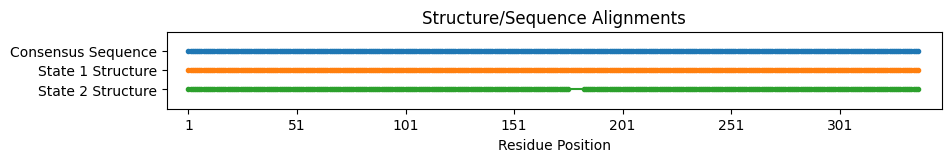

Aligned sequences: 331/337 AA positions present in both structures.
Total of 6289/6403 point mutation sequences generated.


In [ ]:
#@title Generate point mutants
#print sequence lengths
print(f"Consensus sequence: {con_seq}")
print(f"Consensus sequence length: {len(con_seq)}")
print(f"State 1 sequence length: {len(seqs['state1'])}")
print(f"State 2 sequence length: {len(seqs['state2'])}\n")

#find positions present in all structures
positions_present = []
for i in range(len(con_seq)):
    if (i in mappings['state1']) and (i in mappings['state2']) and con_seq[i] in aa_alphabet:
        positions_present.append(i)

con_track = [i for i in range(len(con_seq)) if con_seq[i] in aa_alphabet]
state1_track = [i for i in con_track if i in mappings["state1"]]
state2_track = [i for i in con_track if i in mappings["state2"]]

#visualize sequence alignments
plt.figure(figsize=(10, 1))
plt.plot(con_track, [1.25] * len(con_track), marker=".")
plt.plot(state1_track, [1] * len(state1_track), marker = ".")
plt.plot(state2_track, [0.75] * len(state2_track), marker = ".")
plt.ylim(0.5, 1.5)
test = plt.xticks()[1][0]

def parse_text(s):
    if s[0].isnumeric():
        return int(s)
    else:
        return -1*int(s[1:])
plt.xticks(plt.xticks()[0], [parse_text(i.get_text()) + 1 for i in plt.xticks()[1]])
plt.xlim(-10, len(con_seq) + 10)
plt.yticks([0.75, 1, 1.25], ['State 2 Structure', 'State 1 Structure', 'Consensus Sequence'])
plt.xlabel("Residue Position")
plt.title('Structure/Sequence Alignments')
plt.show()

print(f'Aligned sequences: {len(positions_present)}/{len(con_seq)} AA positions present in both structures.')

#make mutants and create a dataframe
mutants = []
mutant_sequences = []
for i in positions_present:
    aa = con_seq[i]

    for aa_new in aa_alphabet:
        if aa_new != aa:
            mutant_sequences.append(con_seq[:i] + aa_new + con_seq[i + 1 :])
            mutants.append(f"{aa}{i+1}{aa_new}")

print(f'Total of {len(mutants)}/{len(con_seq) * 19} point mutation sequences generated.')

output = pd.DataFrame({'mutant': mutants, 'sequence': mutant_sequences})

In [ ]:
#@title Score all mutants with ProteinMPNN

from scipy.special import softmax

def mpnn_score(seq, model, redesign_aa_pos=None, return_indiv=False):
    L = len(seq)
    ar_mask = 1 - np.eye(L)
    outputs = model.score(seq=seq, ar_mask=ar_mask)
    pssm = softmax(outputs["logits"], -1)
    probs = np.squeeze(pssm[outputs["S"] == 1])
    if redesign_aa_pos is not None:
        probs = [probs[i] for i in redesign_aa_pos]

    if return_indiv:
        return np.log(probs)
    else:
        return np.log(probs).sum()

for structure in pdbs:
    output_scores = []

    mpnn_model.prep_inputs(
        pdb_filename=pdbs[structure],
        chain=chains[structure],
        homooligomer=homooligomer,
        fix_pos=fix_pos,
        inverse=inverse,
        verbose=True,
    )

    wt_seq = mapping_to_sequence(con_seq, seqs[structure], mappings[structure])
    wt_score = mpnn_score(wt_seq, mpnn_model)

    for mut_seq in tqdm(output['sequence']):
        mapped_seq = mapping_to_sequence(mut_seq, seqs[structure], mappings[structure])
        score = mpnn_score(mapped_seq, mpnn_model)
        output_scores.append(score - wt_score)

    output["pmpnn_" + structure] = output_scores

def norm_scale(inp):
    return (inp - np.mean(inp)) / np.std(inp)

output['pmpnn_state1_scaled'] = norm_scale(output['pmpnn_state1'])
output['pmpnn_state2_scaled'] = norm_scale(output['pmpnn_state2'])
output['pmpnn_scaled_mean'] = (output['pmpnn_state1_scaled'] + output['pmpnn_state2_scaled'])/2
output['state1_bias'] = output['pmpnn_state1_scaled'] - output['pmpnn_state2_scaled']
output['state2_bias'] = output['pmpnn_state2_scaled'] - output['pmpnn_state1_scaled']

lengths [337]


  0%|          | 0/6289 [00:00<?, ?it/s]

lengths [331]


  0%|          | 0/6289 [00:00<?, ?it/s]

State1 Predicted Biased Mutants


,mutant,sequence,pmpnn_state1,pmpnn_state2,pmpnn_state1_scaled,pmpnn_state2_scaled,pmpnn_scaled_mean,state1_bias,state2_bias,assignment
2628,Y139E,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-0.529236,-10.537537,1.216924,-2.418859,-0.600967,3.635783,-3.635783,low
2640,Y139V,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,1.016083,-8.832581,1.773380,-1.806249,-0.016434,3.579629,-3.579629,low
2638,Y139T,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,1.829285,-7.766937,2.066207,-1.423351,0.321428,3.489558,-3.489558,low
5207,F281R,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,2.919617,-6.528778,2.458826,-0.978467,0.740180,3.437293,-3.437293,low
2637,Y139S,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,1.014282,-8.208221,1.772732,-1.581910,0.095411,3.354641,-3.354641,low
...,...,...,...,...,...,...,...,...,...,...
5212,F281E,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,0.086853,-4.987061,1.438772,-0.424510,0.507131,1.863283,-1.863283,low
3232,K171N,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,0.324951,-4.703674,1.524510,-0.322686,0.600912,1.847196,-1.847196,low
3290,A174C,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,0.431519,-4.576843,1.562883,-0.277114,0.642884,1.839998,-1.839998,low
4982,D269Q,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-1.584229,-6.537170,0.837031,-0.981482,-0.072226,1.818513,-1.818513,low


State2 Predicted Biased Mutants


,mutant,sequence,pmpnn_state1,pmpnn_state2,pmpnn_state1_scaled,pmpnn_state2_scaled,pmpnn_scaled_mean,state1_bias,state2_bias,assignment
1035,C55L,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-7.762756,4.233185,-1.387803,2.888428,0.750312,-4.276231,4.276231,low
1074,T57L,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-4.485840,6.699127,-0.207814,3.774469,1.783327,-3.982283,3.982283,low
1034,C55I,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-8.009827,2.011658,-1.476771,2.090208,0.306719,-3.566979,3.566979,low
1686,M89S,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-6.359467,3.078735,-0.882491,2.473621,0.795565,-3.356112,3.356112,low
1015,E54I,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-4.982605,4.203247,-0.386695,2.877671,1.245488,-3.264366,3.264366,low
...,...,...,...,...,...,...,...,...,...,...
1021,E54S,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-4.046906,1.900757,-0.049758,2.050360,1.000301,-2.100118,2.100118,low
6104,L328Q,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-9.590576,-3.723022,-2.045985,0.029673,-1.008156,-2.075658,2.075658,low
1676,M89C,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-5.743286,0.125854,-0.660610,1.412618,0.376004,-2.073228,2.073228,low
5450,L293W,STLRLLISDSYDPWFNLAVEECIFRQMPATQRVLFLWRNADTVVIG...,-5.598938,0.209656,-0.608631,1.442729,0.417049,-2.051360,2.051360,low


Text(-4.354997968673707, -4.354997968673707, 'Low Scoring Mutants')

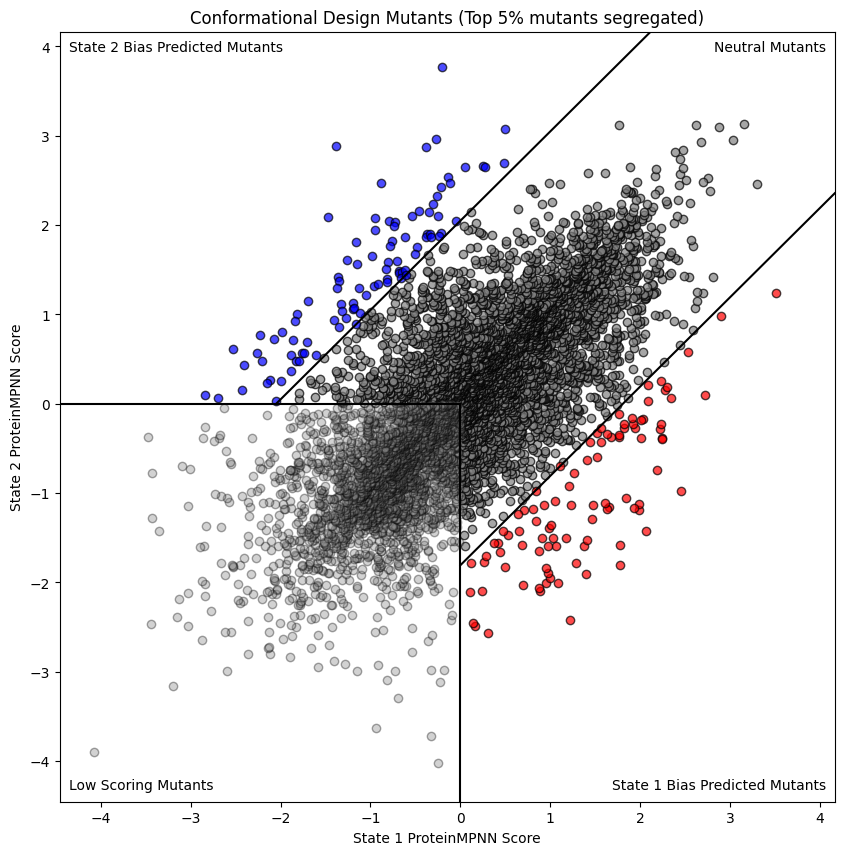

In [ ]:
#@title Visualize results

output = output.sort_values('state1_bias', ascending = False)

passing_mutants = output[(output['pmpnn_state1_scaled'] > 0) | (output['pmpnn_state2_scaled'] > 0)]
nonpassing = output[~((output['pmpnn_state1_scaled'] > 0) | (output['pmpnn_state2_scaled'] > 0))]

n_mutants_passing_filter = len(output[(output['pmpnn_state1_scaled'] > 0) | (output['pmpnn_state2_scaled'] > 0)])
n_biased = round(0.025 * n_mutants_passing_filter)

state1_biased, neutral, state2_biased = passing_mutants[:n_biased], passing_mutants[n_biased:-n_biased], passing_mutants[-n_biased:].sort_values('state2_bias', ascending = False)

state1_cutoff = state1_biased['state1_bias'].iloc[-1]
state2_cutoff = state2_biased['state2_bias'].iloc[-1]

print('State1 Predicted Biased Mutants')
display(state1_biased)
print('State2 Predicted Biased Mutants')
display(state2_biased)

labels = []
for m in output['mutant']:
    label = None
    if m in passing_mutants['mutant']:
        if m in state1_biased['mutant']:
            label = 'state1'
        elif m in state2_biased['mutant']:
            label = 'state2'
        else:
            label = 'neutral'
    else:
        label = 'low'

    labels.append(label)

output['assignment'] = labels

plt.figure(figsize = (10,10))
plt.title('Conformational Design Mutants (Top 5% mutants segregated)')

plt.scatter(neutral['pmpnn_state1_scaled'], neutral['pmpnn_state2_scaled'], marker = 'o', alpha = 0.7, edgecolor = 'black', color = 'grey')
plt.scatter(state1_biased['pmpnn_state1_scaled'], state1_biased['pmpnn_state2_scaled'], marker = 'o', alpha = 0.7, edgecolor = 'black', color = 'red')
plt.scatter(state2_biased['pmpnn_state1_scaled'], state2_biased['pmpnn_state2_scaled'], marker = 'o', alpha = 0.7, edgecolor = 'black', color = 'blue')
plt.scatter(nonpassing['pmpnn_state1_scaled'], nonpassing['pmpnn_state2_scaled'], marker = 'o', alpha = 0.35, edgecolor = 'black', color = 'grey')

#set limits to be equal on both axes
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

umin, umax = min(xmin, ymin), max(xmax, ymax)
plt.xlim(umin, umax)
plt.ylim(umin, umax)

plt.plot([umin, 0], [0,0], color = 'black')
plt.plot([0, 0], [umin,0], color = 'black')

plt.plot([-state2_cutoff, umax-state2_cutoff], [0, umax], color = 'black')
plt.plot([0, umax], [-state1_cutoff, umax -state1_cutoff], color = 'black')

plt.xlabel('State 1 ProteinMPNN Score')
plt.ylabel('State 2 ProteinMPNN Score')

text_offset = 0.1
plt.text(umax - text_offset, umax - text_offset, 'Neutral Mutants', horizontalalignment = 'right', verticalalignment = 'top')
plt.text(umax - text_offset, umin + text_offset, 'State 1 Bias Predicted Mutants', horizontalalignment = 'right', verticalalignment = 'bottom')
plt.text(umin + text_offset, umax - text_offset, 'State 2 Bias Predicted Mutants', horizontalalignment = 'left', verticalalignment = 'top')
plt.text(umin + text_offset, umin + text_offset, 'Low Scoring Mutants', horizontalalignment = 'left', verticalalignment = 'bottom')


In [ ]:
#@title Download CD outputs
output_filepath = f'{jobname}_cd_mutants.csv'
output.to_csv(output_filepath, index = False)
files.download(output_filepath)